<a href="https://colab.research.google.com/github/maiaufrrj/BRtrading/blob/main/MetaTrader.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#!pip install pycaret --upgrade pandas --upgrade

In [3]:
import datetime as dt
from statsmodels.tsa.stattools import adfuller
import numpy as np
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
import sklearn.model_selection as model_selection
from sklearn.model_selection import KFold
#import plotly.graph_objs as go
#import plotly.offline as ply
import pickle
import pandas as pd
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split, TimeSeriesSplit
#from pycaret.regression import *
from pycaret.classification import *
from google.colab import drive

In [ ]:
drive.mount('/content/drive')

In [146]:
filename = '/content/drive/MyDrive/ColabNotebooks/datasets/trading/EURUSD_h1.pkl'
df = pickle.load(open(filename, 'rb'))


'EURUSD_h1.pkl'

def MediaMovelSimples(DF,n):
    ''' função para calcular Média Móvel'''
    df = DF.copy()
    name='MM'+ str(n)  
    df[name] = df['close'].rolling(window=n, min_periods=1).mean()
    df.dropna(inplace=True) 
    return df
    
def DesvioPadrao(DF,n):
    ''' função para calcular Desvio Padrão'''
    df = DF.copy()
    name='STD'+ str(n)
    df[name] = df['close'].rolling(window=n, min_periods=1).std()
    df.dropna(inplace=True)  
    return df

def MediaMovelExponcial(DF,n):
    ''' função para calcular Desvio Padrão'''
    df = DF.copy()
    name='EWM'+ str(n)
    df[name] = df['close'].ewm(span=n).mean()
    df.dropna(inplace=True) 
    return df


 #ohlcv = pdr.get_data_yahoo(ticker,start,end)
    
def ATR(DF,n):
    '''função para calcular TR e ATR'''    
    df = DF.copy()
    name1='ATR'+ str(n)
    name2='TR' + str(n)
    df['H-L'] = abs(df['high']-df['low'])
    df['H-PC']= abs(df['high']-df['close'].shift(1))
    df['L-PC']=abs(df['low']-df['close'].shift(1))
    df[name2]=  df[['H-L','H-PC', 'L-PC']].max(axis=1,skipna=False)
    df[name1]= df[name2].rolling(n).mean()
    df = df.drop(['H-L','H-PC', 'L-PC'],axis=1)
    df.dropna(inplace=True) 
    return df
  
def BollBnd(DF,n):
    '''função para calcular Bandas de Bollinger''' 
    df = DF.copy()
    name1='BBsup'+ str(n)
    name2='BBinf'+ str(n)
    name3='BBlarg'+ str(n)
    df['MA'] = df['close'].rolling(n).mean()
    df[name1] = df['MA'] + 2*df['MA'].rolling(n).std()
    df[name2] = df['MA'] - 2*df['MA'].rolling(n).std()
    df[name3] = df[name1]-df[name2]
    df = df.drop(['MA'],axis=1)
    df.dropna(inplace=True)
    return df

def RSI(DF,n):
    '''função para calcular RSI (Índice de Força Relativa)''' 
    df = DF.copy()
    name='RSI'+ str(n)
    df['delta'] = df['close'] - df['close'].shift(1)
    df['gain'] = np.where(df['delta']>=0,df['delta'],0)
    df['loss'] = np.where(df['delta']<0,abs(df['delta']),0)
    avg_gain = [] 
    avg_loss = []
    gain = df['gain'].tolist()
    loss= df['loss'].tolist()
    for i in range(len(df)):
        if i < n:
            avg_gain.append(np.NaN)
            avg_loss.append(np.NaN)
        elif i==n:
            avg_gain.append(df['gain'].rolling(n).mean().tolist()[n])
            avg_loss.append(df['loss'].rolling(n).mean().tolist()[n])
        elif i>n:
            avg_gain.append(((n-1)*avg_gain[i-1]+gain[i])/n)
            avg_loss.append(((n-1)*avg_loss[i-1]+loss[i])/n)   
    
    df['avg_gain']=np.array(avg_gain)
    df['avg_loss']=np.array(avg_loss)
    df['RS']=df['avg_gain']/df['avg_loss']
    df[name]=100-(100/(1+df['RS']))
    df = df.drop(['delta','avg_gain','avg_loss','loss','gain','RS'],axis=1)
    df.dropna(inplace=True)  
    return df

   
def nIndicadores(DF,n):
    df=DF.copy()
    df = MediaMovelSimples(df,n)
    df = DesvioPadrao(df,n)
    df = MediaMovelExponcial(df,n)
    df = ATR(df,n)
    df = BollBnd(df,n)
    df = RSI(df,n)
    return df

lista=[5,7,9,20,120]
for n in lista:
    df=nIndicadores(df,n)

#del cl_price

'''CRIANDO VARIAVEL DE PREVISÃO (Y) '''

def Forecast(DF,n):
    '''Busca os n preços de fechamento a frente'''
    df = DF.copy()
    df['y']=df['close'].shift(-n)
    df.dropna(inplace=True)
    return df

def movimento_alta(DF,n,percentual_alta):
    '''Verifica se o preço de fechamento n períodos a frente é maior que um certo limite percentual (alta)'''
    df = DF.copy()
    df['delta'] = (df['close'].shift(-n) - df['close'])/df['close']
    df['alta'] = np.where(df['delta']>=percentual_alta,1,0)
    df = df.drop(['delta'],axis=1)
    df.dropna(inplace=True)  
    return df
    

#def movimento_baixa(DF,n,percentual_baixa):
    '''Verifica se o preço de fechamento n períodos a frente é menor que um certo limite percentual (alta)'''
#    df = DF.copy()
#    df['delta'] = (df['close'].shift(-n) - df['close'])/df['close']
#    df['baixa'] = np.where(df['delta']<=-percentual_baixa,1,0)
#    df = df.drop(['delta'],axis=1)
#    df.dropna(inplace=True)  
#    return df

#def movimento_baixa(DF, baixa_esperada, periodos_frente):
#    '''avalia n períodos à frente, se o valor máximo atinge a alta_esperada'''
#    df = DF.copy()

#    '''cria n colunas delta, uma para cada período a frente e calcula a diferença entre fechamento futuro e atual'''
#    for i in range(periodos_frente):
#      name='delta'+str(i)
#      df[name] = (df['close'].shift(-i) - df['close'])/df['close']
#
#    for i in range(periodos_frente):
#      df['baixa'] = np.where(df['delta'+str(i)]<=-baixa_esperada,1,0)
    
#    for i in range(periodos_frente):
#      name='delta'+str(i)
#      df = df.drop([name],axis=1)
  
#    df.dropna(inplace=True)
#    return df



def movimento_baixa(DF, baixa_esperada, periodos_frente):
    '''avalia n períodos à frente, se o valor máximo atinge a alta_esperada'''
    df = DF.copy()

    '''cria n colunas delta, uma para cada período a frente e calcula a diferença entre fechamento futuro e atual'''
    for i in range(periodos_frente):
      name='delta_close'+str(i)
      df[name] = (df['close'].shift(-i) - df['close'])/df['close']
      name='delta_low'+str(i)
      df[name] = (df['low'].shift(-i) - df['close'])/df['close']
      name='delta_high'+str(i)
      df[name] = (df['high'].shift(-i) - df['close'])/df['close']

    for i in range(periodos_frente):
      df['baixa'] = np.where((df['delta_close'+str(i)]<=-baixa_esperada) | (df['delta_low'+str(i)]<=-baixa_esperada) | (df['delta_high'+str(i)]<=-baixa_esperada), 1, 0)
    
    for i in range(periodos_frente):
      name1='delta_close'+str(i)
      name2='delta_low'+str(i)
      name3='delta_high'+str(i)
      df = df.drop([name1,name2,name3],axis=1)

    df.dropna(inplace=True)
    return df




def look_forward(DF, alta_esperada, periodos_frente):
    '''avalia n períodos à frente, se o valor máximo atinge a alta_esperada'''
    df = DF.copy()

    '''cria n colunas delta, uma para cada período a frente e calcula a diferença entre fechamento futuro e atual'''
    for i in range(periodos_frente):
      name='delta_close'+str(i)
      df[name] = (df['close'].shift(-i) - df['close'])/df['close']
      #name='delta_low'+str(i)
      #df[name] = (df['low'].shift(-i) - df['close'])/df['close']
      #name='delta_high'+str(i)
      #df[name] = (df['high'].shift(-i) - df['close'])/df['close']

    for i in range(periodos_frente):
      #df['look_forward'] = np.where((df['delta_close'+str(i)]>=alta_esperada) | (df['delta_low'+str(i)]>=alta_esperada) | (df['delta_high'+str(i)]>=alta_esperada), 1, 0)
      df['look_forward'] = np.where(df['delta_close'+str(i)]>=alta_esperada,1,0)

    for i in range(periodos_frente):
      name1='delta_close'+str(i)
      df = df.drop([name1],axis=1)
      #name2='delta_low'+str(i)
      #name3='delta_high'+str(i)
      #df = df.drop([name1,name2,name3],axis=1)

    df.dropna(inplace=True)
    return df


#definindo intervalo de previsão. n=1 >> previsão do período posterior
#df = Forecast(df,2)
baixa_esperada = 0.004
df = movimento_baixa(df,baixa_esperada,6)

percentual_alta = 0.004
alta_esperada = 0.004
df = look_forward(df,alta_esperada,6) #target
#df = movimento_alta(df,5,percentual_alta) #target

#print(f'altas: {df.alta.sum()}, baixas:{df.baixa.sum()}')

#definindo o target = alta
df['y']=df['look_forward']
del df['look_forward']


In [44]:
df.head(20)

,open,high,low,close,tick_volume,spread,real_volume,MM5,STD5,EWM5,TR5,ATR5,BBsup5,BBinf5,BBlarg5,RSI5,MM7,STD7,EWM7,TR7,ATR7,BBsup7,BBinf7,BBlarg7,RSI7,MM9,STD9,EWM9,TR9,ATR9,BBsup9,BBinf9,BBlarg9,RSI9,MM20,STD20,EWM20,TR20,ATR20,BBsup20,BBinf20,BBlarg20,RSI20,MM120,STD120,EWM120,TR120,ATR120,BBsup120,BBinf120,BBlarg120,RSI120,baixa,y
time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-04-23 17:00:00,1.07942,1.08468,1.07914,1.08278,7654,0,0,1.079046,0.002359,1.080070,0.00554,0.003166,1.080224,1.077868,0.002355,73.583071,1.078889,0.002052,1.079869,0.00554,0.002877,1.080866,1.076911,0.003956,66.361085,1.079276,0.002003,1.079871,0.00554,0.002889,1.081069,1.077482,0.003587,61.827675,1.080614,0.001868,1.080660,0.00554,0.001825,1.083493,1.077735,0.005759,52.300150,1.084699,0.002484,1.084764,0.00554,0.001638,1.089574,1.079824,0.009749,48.716804,1,0
2020-04-23 18:00:00,1.08278,1.08376,1.08082,1.08138,4536,0,0,1.079810,0.002376,1.080507,0.00294,0.003314,1.081430,1.078190,0.003241,59.970144,1.079139,0.002254,1.080247,0.00294,0.003117,1.080624,1.077653,0.002971,56.684166,1.079244,0.001964,1.080173,0.00294,0.002959,1.080890,1.077599,0.003292,54.235573,1.080592,0.001856,1.080729,0.00294,0.001920,1.083450,1.077734,0.005716,48.587677,1.084677,0.002502,1.084708,0.00294,0.001642,1.089557,1.079796,0.009761,47.961280,1,0
2020-04-23 19:00:00,1.08142,1.08188,1.08086,1.08138,3644,0,0,1.080764,0.001601,1.080798,0.00102,0.002942,1.083166,1.078362,0.004804,59.970144,1.079713,0.002238,1.080530,0.00102,0.002827,1.080833,1.078593,0.002240,56.684166,1.079442,0.002089,1.080414,0.00102,0.002678,1.080850,1.078034,0.002816,54.235573,1.080545,0.001822,1.080791,0.00102,0.001929,1.083354,1.077737,0.005616,48.587677,1.084660,0.002517,1.084653,0.00102,0.001622,1.089545,1.079775,0.009770,47.961280,0,0
2020-04-23 20:00:00,1.08138,1.08146,1.07645,1.07654,6005,0,0,1.080300,0.002418,1.079379,0.00501,0.003356,1.082508,1.078092,0.004416,29.995050,1.079567,0.002426,1.079533,0.00501,0.003229,1.080482,1.078652,0.001830,33.617024,1.079099,0.002298,1.079639,0.00501,0.003094,1.080188,1.078010,0.002178,35.280193,1.080264,0.001985,1.080386,0.00501,0.002155,1.083021,1.077506,0.005514,38.200461,1.084597,0.002624,1.084519,0.00501,0.001649,1.089487,1.079707,0.009780,45.481626,0,0
2020-04-23 21:00:00,1.07654,1.07874,1.07619,1.07854,3475,0,0,1.080124,0.002528,1.079099,0.00255,0.003412,1.081403,1.078845,0.002557,44.360082,1.079843,0.002125,1.079285,0.00255,0.003181,1.080906,1.078779,0.002127,44.504374,1.079230,0.002219,1.079420,0.00255,0.003039,1.079952,1.078508,0.001443,44.325830,1.080075,0.001959,1.080210,0.00255,0.002265,1.082767,1.077383,0.005384,43.458252,1.084547,0.002681,1.084420,0.00255,0.001661,1.089442,1.079653,0.009788,46.631381,0,0
2020-04-23 22:00:00,1.07853,1.07887,1.07795,1.07822,2409,0,0,1.079212,0.002120,1.078806,0.00092,0.002488,1.080368,1.078056,0.002313,42.611312,1.079751,0.002188,1.079018,0.00092,0.002893,1.080809,1.078694,0.002115,43.182353,1.079303,0.002167,1.079180,0.00092,0.002897,1.079698,1.078908,0.000790,43.238052,1.079954,0.001997,1.080021,0.00092,0.002224,1.082570,1.077339,0.005230,42.844337,1.084494,0.002743,1.084318,0.00092,0.001661,1.089393,1.079596,0.009796,46.473249,0,0
2020-04-23 23:00:00,1.07823,1.07829,1.07649,1.07758,1517,0,0,1.078452,0.001806,1.078397,0.00180,0.002260,1.080307,1.076597,0.003711,38.788496,1.079489,0.002339,1.078659,0.00180,0.002826,1.080188,1.078789,0.001399,40.383280,1.079411,0.002037,1.078860,0.00180,0.002777,1.079670,1.079153,0.000517,40.975540,1.079776,0.002044,1.079788,0.00180,0.002267,1.082303,1.077250,0.005054,41.606944,1.084442,0.002814,1.084206,0.00180,0.001662,1.089344,1.079539,0.009804,46.157568,0,0
2020-04-24 00:00:00,1.07762,1.07851,1.07715,1.07771,724,3,0,1.077718,0.000764,1.078168,0.00136,0.002328,1.079912,1.075524,0.004387,40.151770,1.078764,0.001893,1.078422,0.00136,0.002229,1.079537,1.077992,0.001545,41.285195,1.079283,0.002110,1.078630,0.00136,0.002601,1.079484,1.079083,0.000401,41.672985,1.079572,0.

In [9]:
workbook='/content/drive/MyDrive/ColabNotebooks/datasets/trading/dataframe_eurusd.xlsx'
df.to_excel(workbook)

In [147]:
#def rename_target(DF,target):
#  df = DF.copy()
#  for i in range(df.columns):
#    df['y'] = df[target] 
#  if (df.columns[-1] == 'alta') | (df.columns[-1] == 'baixa'):
#    df = DF.copy()

#intialize the setup
separar=720 #separando 720hs de dataset (1 mês)
df_validacao = df.iloc[-separar:,:]

df_train = df.iloc[:-(separar-1),:]

X= df_train.iloc[:,:-1]  #da primeira à penultima (variáveis dependentes)
y= df_train.iloc[:,-1]    #ultima coluna (dados de previsão)

In [18]:
#exp_clf = setup(df_train, target = 'y', fold_strategy = 'timeseries', fold = 15, train_size=0.7, feature_selection = True, feature_selection_threshold = 0.70 ,session_id = 123)

#balanceamento SMOTE
exp_clf = setup(df_train,
                target = 'y', 
                fold_strategy = 'timeseries',
                fold = 15,
                train_size=0.7,
                feature_selection = True,
                fix_imbalance = True,
                feature_selection_threshold = 0.70,
                remove_multicollinearity = True,
                normalize = True,
                session_id = 123)

#transform_target = True ---item de regressao

,Description,Value
0,session_id,123
1,Target,y
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(8642, 54)"
5,Missing Values,False
6,Numeric Features,52
7,Categorical Features,1
8,Ordinal Features,False
9,High Cardinality Features,False


In [19]:
best = compare_models(sort = 'MCC')

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
et,Extra Trees Classifier,0.9792,0.7949,0.3013,0.5192,0.3631,0.3542,0.3761,0.7567
rf,Random Forest Classifier,0.9677,0.7953,0.2581,0.2684,0.2491,0.2336,0.2403,2.1160
lightgbm,Light Gradient Boosting Machine,0.9614,0.7858,0.2781,0.2120,0.2198,0.2019,0.2133,0.3500
dt,Decision Tree Classifier,0.9335,0.6326,0.3170,0.1079,0.1519,0.1259,0.1504,0.1713
gbc,Gradient Boosting Classifier,0.8862,0.7449,0.4045,0.0940,0.1384,0.1082,0.1456,2.8413
ada,Ada Boost Classifier,0.8354,0.7029,0.4041,0.0606,0.0975,0.0637,0.1001,0.7040
lda,Linear Discriminant Analysis,0.7332,0.6934,0.5404,0.0427,0.0780,0.0399,0.0871,0.0447
ridge,Ridge Classifier,0.7330,0.0000,0.5404,0.0426,0.0779,0.0398,0.0870,0.0293
lr,Logistic Regression,0.7333,0.6709,0.5246,0.0427,0.0773,0.0394,0.0838,0.4740
nb,Naive Bayes,0.3765,0.6781,0.8263,0.0293,0.0560,0.0148,0.0597,0.0300


In [21]:
#criando modelos
model = create_model(best)
model_tuned = tune_model(estimator = model,  fold = 15,  round = 4,  n_iter = 100,  optimize = 'MCC', verbose = True)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.9577,0.7587,0.4000,0.1333,0.2000,0.1838,0.2137
1,0.9444,0.6373,0.3125,0.3333,0.3226,0.2936,0.2938
2,0.9259,0.8059,0.2000,0.0400,0.0667,0.0456,0.0624
3,0.9286,0.7771,0.2857,0.0833,0.1290,0.1033,0.1252
4,0.8968,0.6826,0.2000,0.0278,0.0488,0.0262,0.0413
5,0.9153,0.7742,0.3000,0.1071,0.1579,0.1237,0.1422
6,0.9127,0.8534,0.5833,0.2000,0.2979,0.2630,0.3066
7,0.9153,0.7624,0.5714,0.1212,0.2000,0.1748,0.2356
8,0.8968,0.7485,0.4000,0.0526,0.0930,0.0713,0.1153
9,0.9153,0.9068,0.7500,0.1667,0.2727,0.2466,0.3280


In [22]:
evaluate_model(model_tuned)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

In [23]:
#finalize a model
final_model = finalize_model(model_tuned)
save_model(final_model, '/content/drive/MyDrive/ColabNotebooks/datasets/trading/modelos/et_tuned')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=[],
                                       display_types=True, features_todrop=[],
                                       id_columns=[],
                                       ml_usecase='classification',
                                       numerical_features=[], target='y',
                                       time_features=[])),
                 ('imputer',
                  Simple_Imputer(categorical_strategy='not_available',
                                 fill_value_categorical=None,
                                 fill_value_numerical=None,
                                 numeric_strategy='...
                  ExtraTreesClassifier(bootstrap=True, ccp_alpha=0.0,
                                       class_weight={}, criterion='gini',
                                       max_depth=11, max_features=1.0,
                                       max_leaf_nodes=None,

In [ ]:
#salvando modelo
#import pickle
#filename = '/content/drive/MyDrive/ColabNotebooks/datasets/trading/modelos/et_tuned01.pkl'
#pickle.dump(final_model, open(filename, 'wb'))

In [148]:
# generate predictions on the original dataset
predictions_df = predict_model(model_tuned, data=df_train)
predictions_df = predictions_df.reset_index()

def alinhar_pontos(DF):
    '''cria uma coluna, em que o valor da Label será igual ao close*(1+percentual_alta) caso Label=1 '''
    df = DF.copy()
    df['Label'] = np.where(df['Label']==1,df['close'],0)
    df['baixa'] = np.where(df['baixa']==1,df['close'],0)
    return df

predictions_df = alinhar_pontos(predictions_df)

In [149]:
# line plot
import plotly.express as px
import plotly.graph_objects as go
fig = px.line(predictions_df, x='time', y='close', template = 'plotly_dark')

#fig = go.Figure(data=[go.Candlestick(x=predictions_df['time'],
#                open=predictions_df['open'],
#                high=predictions_df['high'],
#                low=predictions_df['low'],
#                close=predictions_df['close'])])

fig.add_scatter(x=predictions_df['time'], y=predictions_df['Label'], mode='markers', marker_color='rgba(0, 255, 0, .8)')
#fig.add_scatter(x=predictions_df_teste['time'], y=predictions_df_teste['baixa'], mode='markers', marker_color='rgba(255, 0, 0, .8)')

ymin=predictions_df.close.min()
ymax=predictions_df.close.max()
fig.update_yaxes(range=[ymin, ymax])
fig.show()
fig.write_html('/content/drive/MyDrive/ColabNotebooks/datasets/trading/modelos/et_tuned.html')

In [27]:
#! pip install backtrader

In [150]:
# testando dados no dataset de validação
predictions_df_teste = predict_model(model_tuned, data=df_validacao)
predictions_df_teste = predictions_df_teste.reset_index()

8

In [151]:
def alinhar_pontos(DF):
    '''cria uma coluna, em que o valor da Label será igual ao close*(1+percentual_alta) caso Label=1 '''
    df = DF.copy()
    df['Label'] = np.where(df['Label']==1,df['close'],0)
    #df = df.drop(['delta'],axis=1)
    #df.dropna(inplace=True)  
    return df

predictions_df_teste = alinhar_pontos(predictions_df_teste)


In [152]:
import plotly.express as px
import plotly.graph_objects as go
fig = px.line(predictions_df_teste, x='time', y='close', template = 'plotly_dark')
fig.add_scatter(x=predictions_df_teste['time'], y=predictions_df_teste['Label'], mode='markers', marker_color='rgba(0, 255, 0, .8)')
#fig.add_scatter(x=predictions_df_teste['time'], y=predictions_df_teste['baixa'], mode='markers', marker_color='rgba(255, 0, 0, .8)')

ymin=predictions_df_teste.close.min()
ymax=predictions_df_teste.close.max()
fig.update_yaxes(range=[ymin, ymax])

fig.show()
fig.write_html("et_valid_mcc.html")

In [208]:
#!pip install bta-lib
#!pip install bt
import btalib as bta

In [ ]:
close = pd.DataFrame()
close['sinal'] = np.where(predictions_df_teste['Label']>=1,1,0)
close['sinal'] = pd.to_numeric(close['sinal'])
close.set_index(predictions_df_teste.time, inplace=True)
close.fillna(0)
#close.value_counts()

venda = pd.DataFrame()
venda['sinal'] =np.where(predictions_df_teste['baixa']!=0,-1,0)
venda['sinal'] = pd.to_numeric(venda['sinal'])
venda.fillna(0)
#venda.value_counts()

posicao = venda.copy()
posicao['sinal'] = 0
posicao[close.values == 1] = 1.0
posicao[venda.values == -1] = -1.0
posicao.set_index(predictions_df_teste.time, inplace=True)
posicao['sinal'].fillna(0)
#posicao.head(20)

In [236]:
close = pd.DataFrame()
close['sinal'] = predictions_df_teste['close']
close.set_index(predictions_df_teste.time, inplace=True)

#3. Criar estrutura de backtesting

In [ ]:
#https://pmorissette.github.io/bt/
#https://colab.research.google.com/drive/1K56P-z6RK01tLYSvfRVadxQGKUp7h7VO?usp=sharing#scrollTo=EepGT0mwt6ou

In [140]:
# download data
# calculate moving average DataFrame using pandas' rolling_mean
# a rolling mean is a moving average, right?
#sma = df_train.close.rolling(5).mean()

In [237]:
import bt
et_strategy = bt.Strategy('et_strategy', [bt.algos.WeighTarget(posicao),
                                bt.algos.Rebalance()])

et_teste = bt.Backtest(et_strategy, close)
resultado = bt.run(et_teste)
#resultado.display()
#resultado.plot()
#resultado.plot_weights('et_strategy')

In [238]:
s1 = bt.Strategy('s1', [bt.algos.SelectAll(),
                        bt.algos.WeighTarget(posicao),
                        bt.algos.Rebalance()])

s1_teste = bt.Backtest(s1, close, initial_capital=1000)
#, commissions=0.1)
                 #integer_positions=integer_positions)

res = bt.run(s1_teste)
#res.display()
#res.plot()
#res.plot_weights('s1')

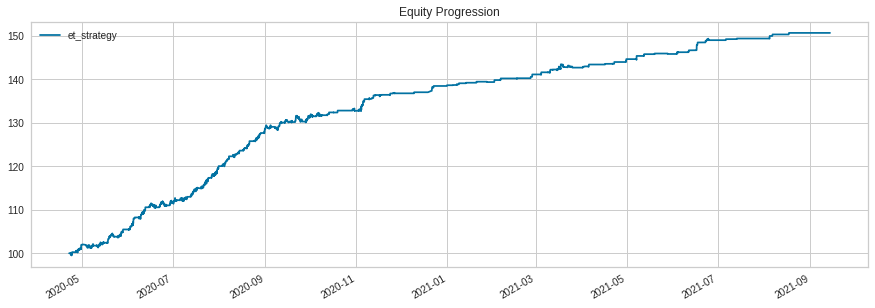

In [ ]:
resultado.plot()

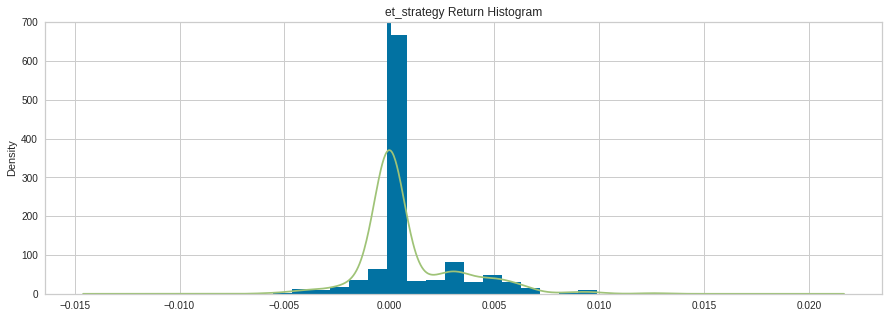

In [ ]:
resultado.plot_histogram()

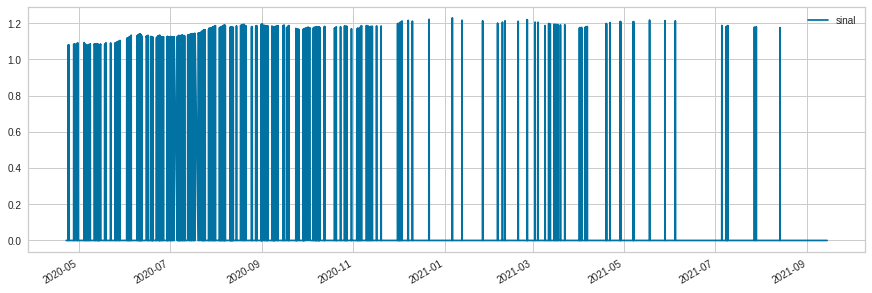

In [ ]:
resultado.plot_security_weights()

In [239]:
# create our new strategy
s2 = bt.Strategy('s2', [bt.algos.RunDaily(),
                        bt.algos.SelectAll(),
                        bt.algos.WeighInvVol(),
                        bt.algos.Rebalance()])

# now let's test it with the same data set. We will also compare it with our first backtest.
s2_teste = bt.Backtest(s2, close)
# we include test here to see the results side-by-side
resultado2 = bt.run(s1_teste, s2_teste)
#resultado2.display()

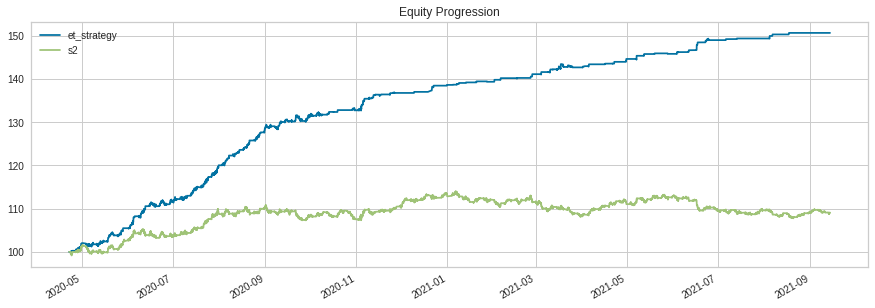

In [ ]:
resultado2.plot()

In [240]:

btc_close = pd.DataFrame()
btc_close['sinal'] = predictions_df_teste['close']

btc_close.set_index(predictions_df_teste['time'], inplace=True)
btc_bands = bta.bbands(btc_close, period=20, devs=2.0).df
btc_up = pd.DataFrame()
btc_down = pd.DataFrame()

btc_down['sinal'] = btc_bands['bot']
btc_up['sinal'] =btc_bands['top']
btc_down['sinal'] = pd.to_numeric(btc_down['sinal'])
btc_up['sinal'] = pd.to_numeric(btc_up['sinal'])

btc_down.fillna(0)
btc_up.fillna(0)

posicao2 = btc_up.copy()
posicao2['sinal'] = 0

posicao2[btc_close > btc_up] = -1.0
posicao2[btc_close <= btc_down] = 1.0
posicao2['sinal'].fillna(0)

bbands = bt.Strategy('bbands', [bt.algos.WeighTarget(posicao2),
                                bt.algos.Rebalance()])

bteste = bt.Backtest(bbands, btc_close)

resultado2 = bt.run(bteste)
#resultado2.display()
#resultado2.plot()
#resultado2.plot_weights('bbands')

mm50 = pd.DataFrame()
mmm200 = pd.DataFrame()
mm50 = bta.sma(btc_close.sinal, period=50).df
mm200 = bta.sma(btc_close.sinal, period=200).df
mm50['sinal'] = mm50
mm200['sinal'] =mm200
posicao_2 = btc_up.copy()
posicao_2['sinal'] =0
posicao_2[mm50 > mm200] = 1.0
posicao_2[mm50 <=mm200] = -1.0
posicao_2.fillna(0)
mmovel = bt.Strategy('mmovel', [bt.algos.WeighTarget(posicao_2),
                                bt.algos.Rebalance()])

teste_sma = bt.Backtest(mmovel, btc_close)

benchmark = bt.Strategy('benchmark', [bt.algos.RunYearly(),
                                      bt.algos.SelectAll(),
                                      bt.algos.WeighEqually(),
                                      bt.algos.Rebalance()])

benchmark_teste = bt.Backtest(benchmark, btc_close)
b_resultado = bt.run(et_teste, bteste, teste_sma, benchmark_teste)
b_resultado.display()

Stat                 et_strategy    bbands      mmovel      benchmark
-------------------  -------------  ----------  ----------  -----------
Start                2021-09-13     2021-09-13  2021-09-13  2021-09-13
End                  2021-10-26     2021-10-26  2021-10-26  2021-10-26
Risk-free rate       0.00%          0.00%       0.00%       0.00%

Total Return         1.19%          -0.14%      1.36%       -1.73%
Daily Sharpe         5.32           -0.47       3.10        -3.39
Daily Sortino        15.88          -0.58       5.52        -5.12
CAGR                 10.58%         -1.15%      12.17%      -13.77%
Max Drawdown         -0.27%         -0.84%      -0.57%      -2.42%
Calmar Ratio         39.82          -1.37       21.37       -5.70

MTD                  0.47%          -0.01%      -0.01%      0.23%
3m                   -              -           -           -
6m                   -              -           -           -
YTD                  1.19%          -0.14%      1.36%     

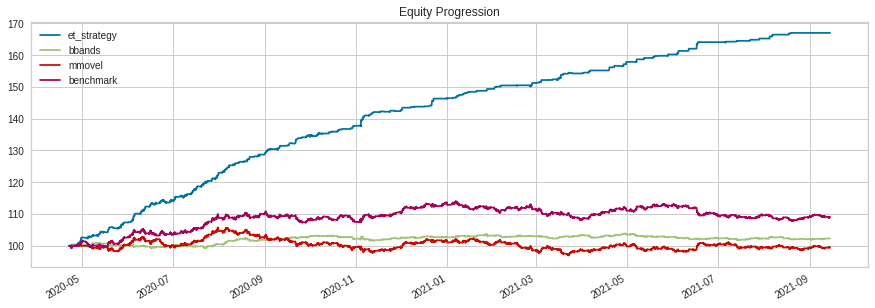

In [223]:
b_resultado.plot()

In [ ]:
#finalize a model
final_model = finalize_model(model_tuned)

In [234]:
df_result = pd.DataFrame(b_resultado)

ValueError: ignored

In [ ]:
model_tuned

ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0,
                     class_weight='balanced_subsample', criterion='gini',
                     max_depth=6, max_features=1.0, max_leaf_nodes=None,
                     max_samples=None, min_impurity_decrease=0,
                     min_impurity_split=None, min_samples_leaf=4,
                     min_samples_split=7, min_weight_fraction_leaf=0.0,
                     n_estimators=200, n_jobs=-1, oob_score=False,
                     random_state=123, verbose=0, warm_start=False)